<H2>AO v2 multicoins Strategy backtest on FTX Exchange</H2>
Indicators: Awesome Oscillator (AO), RSI Stoch, Williams %R, EMA100 and EMA200<br>
Language: EN<br>
SEG, 13.03.2022

In [1]:
import sys
sys.path.append( '../utilities' )
from data_engine import DataEngine
from backtesting import Backtesting
import pandas as pd
import ta
import ccxt
import json
f = open('../database/pair_list.json',)
pairJson = json.load(f)
f.close()

In [2]:
#pairList = pairJson['hitbtc2018']
pairList = pairJson['NewftxClassicPair']
timeframe = '1h'
startDate = '2017-01-01T00:00:00'

#dataEngine = DataEngine(session=ccxt.hitbtc())
dataEngine = DataEngine(session=ccxt.ftx())

dfList = []
for pair in pairList:
    df = dataEngine.get_historical_from_db(pair, timeframe, startDate)
    dfList.append(df)

print("Data load 100%")
#dfList[0]

Successfully load 18090 candles for AAVEUSD
Successfully load 5576 candles for APEUSD
Successfully load 4614 candles for ALGOUSD
Successfully load 5958 candles for ATOMUSD
Successfully load 7892 candles for AVAXUSD
Successfully load 13858 candles for AXSUSD
Successfully load 15973 candles for BANDUSD
Successfully load 23276 candles for BCHUSD
Successfully load 25733 candles for BNBUSD
Successfully load 28853 candles for BTCUSD
Successfully load 17897 candles for CHZUSD
Successfully load 14170 candles for CROUSD
Successfully load 7662 candles for DOTUSD
Successfully load 15856 candles for DOGEUSD
Successfully load 27527 candles for ETHUSD
Successfully load 14872 candles for FTMUSD
Successfully load 28662 candles for FTTUSD
Successfully load 16456 candles for GRTUSD
Successfully load 8739 candles for IMXUSD
Successfully load 21018 candles for KNCUSD
Successfully load 2598 candles for LDOUSD
Successfully load 22266 candles for LINKUSD
Successfully load 23276 candles for LTCUSD
Successfull

In [3]:
# -- Indicator variable --
aoParam1 = 6
aoParam2 = 22
stochWindow = 14
willWindow = 14

# -- Drop all columns we do not need --
for df in dfList:
    # -- Drop all columns we do not need --
    df.drop(columns=df.columns.difference(['open','high','low','close','volume']), inplace=True)

    # -- Indicators --
    df['AO'] = ta.momentum.awesome_oscillator(df['high'],df['low'],window1=aoParam1,window2=aoParam2)
    
    df['EMA100'] =ta.trend.ema_indicator(close=df['close'], window=100)
    df['EMA200'] =ta.trend.ema_indicator(close=df['close'], window=200)

    df['STOCH_RSI'] = ta.momentum.stochrsi(close=df['close'], window=stochWindow)

    df['WillR'] = ta.momentum.williams_r(high=df['high'], low=df['low'], close=df['close'], lbp=willWindow)

print("Indicators loaded 100%")
dfList[0]

Indicators loaded 100%


,open,high,low,close,volume,AO,EMA100,EMA200,STOCH_RSI,WillR
timestamp,,,,,,,,,,
2020-10-12 02:00:00,50.42,51.34,50.25,51.34,341.2267,NaN,NaN,NaN,NaN,NaN
2020-10-12 03:00:00,51.34,51.64,50.56,51.40,7.1960,NaN,NaN,NaN,NaN,NaN
2020-10-12 04:00:00,51.40,51.41,51.16,51.16,44.2040,NaN,NaN,NaN,NaN,NaN
2020-10-12 05:00:00,51.16,51.40,50.85,51.05,0.0000,NaN,NaN,NaN,NaN,NaN
2020-10-12 06:00:00,51.05,51.05,50.56,50.56,0.0000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-11-04 15:00:00,95.41,96.73,93.41,93.43,479820.7855,4.885985,85.802281,84.796283,0.149679,-30.361091
2022-11-04 16:00:00,93.43,94.91,93.20,94.15,260196.2371,4.579394,85.967582,84.889355,0.088895,-28.356964
2022-11-04 17:00:00,94.15,94.75,93.44,94.27,98348.8008,4.390227,86.131986,84.982694,0.104034,-32.669323


In [4]:
dfTestList = []
for df in dfList:
    dfTestList.append(df.loc['2019-01-01':])

# -- Starting value --
startingBalance = 9000
makerFee = 0
takerFee = 0.00063

# -- Rules --
StopLossActivation = False
takeProfitActivation = True
showLog = False

# -- Hyper parameters --
stochOverBought = 0.8
stochOverSold = 0.25
SlPct = 0.015
TpPct = 0.15
willOverSold = -85
willOverBought = -10
maxPositions = 3

# -- Trade Functions --
# -- Condition to BUY market --
def buyCondition(row, previousRow=None):
    if (
        row['AO'] >= 0
        and previousRow['AO'] > row['AO']
        and row['WillR'] < willOverSold
        and row['EMA100'] > row['EMA200']
    ):
        return True
    else:
        return False

# -- Condition to SELL market --
def sellCondition(row, previousRow=None):
    if (
        (row['AO'] < 0
        and row['STOCH_RSI'] > stochOverSold)
        or row['WillR'] > willOverBought
    ):
        return True
    else:
        return False

# -- Value initialisation --
usd = startingBalance
wallet = startingBalance
stopLoss = [0] * len(pairList)
takeProfit = [5000000] * len(pairList)
walletCoinArray = [0] * len(pairList)
walletUsdArray = [0] * len(pairList)
activePositions = 0
lastIndex = dfTestList[0].index.values[1]

# -- Definition of dfTrades, that will be the dataset to do your trades analyses --
dfTrades = None
dfTrades = pd.DataFrame(columns=['date', 'symbol','position', 'reason',
                                 'price', 'frais', 'fiat', 'coins', 'wallet'])

# # -- Iteration on all your price dataset (df) --
for index, row in dfTestList[0].iterrows():
    # -- Check if you have one coin in your wallet --
    if (walletCoinArray.count(0) == len(walletCoinArray)) == False:
        # -- Iteration on all coin (upgrade possible: only check coin in your wallet) --
        for i in range(0,len(dfTestList)):
            # -- Check if you have more than 0 coin --
            if walletCoinArray[i] != 0:
                try:
                    actualRow = dfTestList[i].loc[index]
                    previousRow = dfTestList[i].loc[lastIndex]
                    # -- Stop Loss --
                    if actualRow['low'] < stopLoss[i] :
                        sellPrice = stopLoss[i]
                        usd = usd + walletCoinArray[i] * sellPrice
                        fee = makerFee * walletCoinArray[i] * sellPrice
                        usd = usd - fee
                        # -- Set coin and equivalent usd to 0 after sold position --
                        walletCoinArray[i] = 0
                        walletUsdArray[i] = 0
                        activePositions -= 1

                        # -- LOG --
                        if showLog:
                            print("Sell COIN at Stop Loss", sellPrice, '$ the', index)

                        # -- Add the trade to dfTrades to analyse it later --
                        myrow = {
                            'date': index,
                            'symbol': pairList[i],
                            'position': "Sell",
                            'reason': 'Sell Stop Loss',
                            'price': sellPrice,
                            'frais': fee,
                            'fiat': usd,
                            'coins': 0,
                            'wallet': sum(walletUsdArray) + usd
                        }
                        dfTrades = dfTrades.append(myrow, ignore_index=True)

                    # -- Take Profit --
                    elif actualRow['high'] > takeProfit[i] :
                        sellPrice = takeProfit[i]
                        usd = usd + walletCoinArray[i] * sellPrice
                        fee = makerFee * walletCoinArray[i] * sellPrice
                        usd = usd - fee
                        # -- Set coin and equivalent usd to 0 after sold position --
                        walletCoinArray[i] = 0
                        walletUsdArray[i] = 0
                        activePositions -= 1

                        # -- LOG --
                        if showLog:
                            print("Sell COIN at Take Profit", sellPrice, '$ the', index)

                        # -- Add the trade to dfTrades to analyse it later --
                        myrow = {
                            'date': index,
                            'symbol': pairList[i],
                            'position': "Sell",
                            'reason': 'Sell Take Profit',
                            'price': sellPrice,
                            'frais': fee,
                            'fiat': usd,
                            'coins': 0,
                            'wallet': sum(walletUsdArray) + usd
                        }
                        dfTrades = dfTrades.append(myrow, ignore_index=True)

                    # -- Sell Market --
                    elif sellCondition(actualRow,previousRow):
                        sellPrice = actualRow['close']
                        usd = usd + walletCoinArray[i] * sellPrice
                        fee = takerFee * walletCoinArray[i] * sellPrice
                        usd = usd - fee
                        # -- Set coin and equivalent usd to 0 after sold position --
                        walletCoinArray[i] = 0
                        walletUsdArray[i] = 0
                        activePositions -= 1

                        # -- LOG --
                        if showLog:
                            print("Sell", pairList[i],"at", sellPrice, '$ the', index)

                        # -- Add the trade to DfTrades to analyse it later --
                        myrow = {
                            'date': index,
                            'symbol': pairList[i],
                            'position': "Sell",
                            'reason': 'Sell Market Order',
                            'price': sellPrice,
                            'frais': fee,
                            'fiat': usd,
                            'coins': 0,
                            'wallet': sum(walletUsdArray) + usd
                        }
                        dfTrades = dfTrades.append(myrow, ignore_index=True)
                except:
                    pass
    
    # -- Buy market order --
    # -- Check if you can open a new position --
    if activePositions < maxPositions:
        # -- Check buy condition for each coin of list --
        for i in range(0,len(dfTestList)):
            try:
                actualRow = dfTestList[i].loc[index]
                previousRow = dfTestList[i].loc[lastIndex]
                # -- Buy condition --
                if buyCondition(actualRow, previousRow) and activePositions < maxPositions and walletCoinArray[i]==0 :
                    buyPrice = actualRow['close']
                    # -- Define size of the position --
                    usdMultiplier = 1/(maxPositions-activePositions)
                    fee = takerFee * usd * usdMultiplier
                    usd = usd - fee
                    coin = (usd * usdMultiplier) / buyPrice
                    usd = usd - (usd * usdMultiplier)
                    # -- Set coin and equivalent usd to size of position after open position --
                    walletCoinArray[i] = coin
                    walletUsdArray[i] = coin * actualRow['close']
                    activePositions += 1
                    # -- Create a Stop Loss --
                    if StopLossActivation:
                        stopLoss[i] = buyPrice - SlPct * buyPrice
                    # -- Create a Take Profit --
                    if takeProfitActivation:
                        takeProfit[i] = buyPrice + TpPct * buyPrice

                    # -- LOG --
                    if showLog:
                        print("Buy", pairList[i],"at", buyPrice, '$ the', index)

                    # -- Add the trade to dfTrades to analyse it later --
                    myrow = {
                        'date': index,
                        'symbol': pairList[i],
                        'position': "Buy",
                        'reason': 'Buy Market Order',
                        'price': buyPrice,
                        'frais': fee,
                        'fiat': usd,
                        'coins': coin,
                        'wallet': sum(walletUsdArray) + usd
                    }
                    dfTrades = dfTrades.append(myrow, ignore_index=True)
            except:
                pass

    # -- Keep last index to define last row --            
    lastIndex = index

print("Final wallet", sum(walletUsdArray) + usd)


C:\Users\jacks\AppData\Local\Temp\ipykernel_16872\2741149867.py:207: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrades = dfTrades.append(myrow, ignore_index=True)
C:\Users\jacks\AppData\Local\Temp\ipykernel_16872\2741149867.py:207: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrades = dfTrades.append(myrow, ignore_index=True)
C:\Users\jacks\AppData\Local\Temp\ipykernel_16872\2741149867.py:207: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrades = dfTrades.append(myrow, ignore_index=True)
C:\Users\jacks\AppData\Local\Temp\ipykernel_16872\2741149867.py:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrades = dfTrades.appen

Final wallet 55439.36214865965


In [10]:
newDf.iloc[-2:]

,date,symbol,position,reason,price,frais,fiat,coins,wallet,resultat,resultat%,tradeIs,walletAth,drawDown,drawDownPct
date,,,,,,,,,,,,,,,
2022-11-04 04:00:00,2022-11-04 04:00:00,SUSHI/USD,Buy,Buy Market Order,1.7158,11.558275,36685.229500,10690.415404,55027.844250,NaN,NaN,,57205.718381,2177.874131,0.038071
2022-11-04 05:00:00,2022-11-04 05:00:00,SUSHI/USD,Sell,Sell Market Order,1.7554,11.822552,55439.362149,0.000000,55439.362149,411.517898,0.747836,Good,57205.718381,1766.356233,0.030877


In [9]:
BTobject = Backtesting()
newDf = BTobject.multi_spot_backtest_analys(dfTrades=dfTrades, dfTest=dfTestList[0], pairList=pairList, timeframe=timeframe)

Trading Bot on : 34 coins | Timeframe : 1h
Period : [2020-10-12 02:00:00] -> [2022-11-04 19:00:00]
Starting balance : 8998.11 $

----- General Informations -----
Final balance : 55439.36 $
Performance vs US Dollar : 516.12 %
Bitcoin Buy and Hold Performance : 83.77 %
Performance vs Buy and Hold : 235.26 %
Best trade : +5.0 %, the 2021-08-26 08:00:00
Worst trade : -9.27 %, the 2021-12-04 07:00:00
Worst drawDown : - 30.94 %
Total fees :  31443.19 $

----- Trades Informations -----
Total trades on period : 1912
Number of positive trades : 1234
Number of negative trades :  678
Trades win rate ratio : 64.54 %
Average trades performance : 0.12 %
Average positive trades : 0.65 %
Average negative trades : -0.85 %

----- Trades Reasons -----
Buy Market Order     1912
Sell Market Order    1898
Sell Take Profit       14
Name: reason, dtype: int64

----- Pair Result -----
-----------------------------------------------------------------------------------------------
Trades      Pair     Sum-result

d:\Cryptobots\cBot-Project_jack\backtest\../utilities\backtesting.py:333: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTemp = dfTemp.append(myrow, ignore_index=True)
d:\Cryptobots\cBot-Project_jack\backtest\../utilities\backtesting.py:333: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTemp = dfTemp.append(myrow, ignore_index=True)
d:\Cryptobots\cBot-Project_jack\backtest\../utilities\backtesting.py:333: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTemp = dfTemp.append(myrow, ignore_index=True)


----- 2020 Performances: 24.86% -----


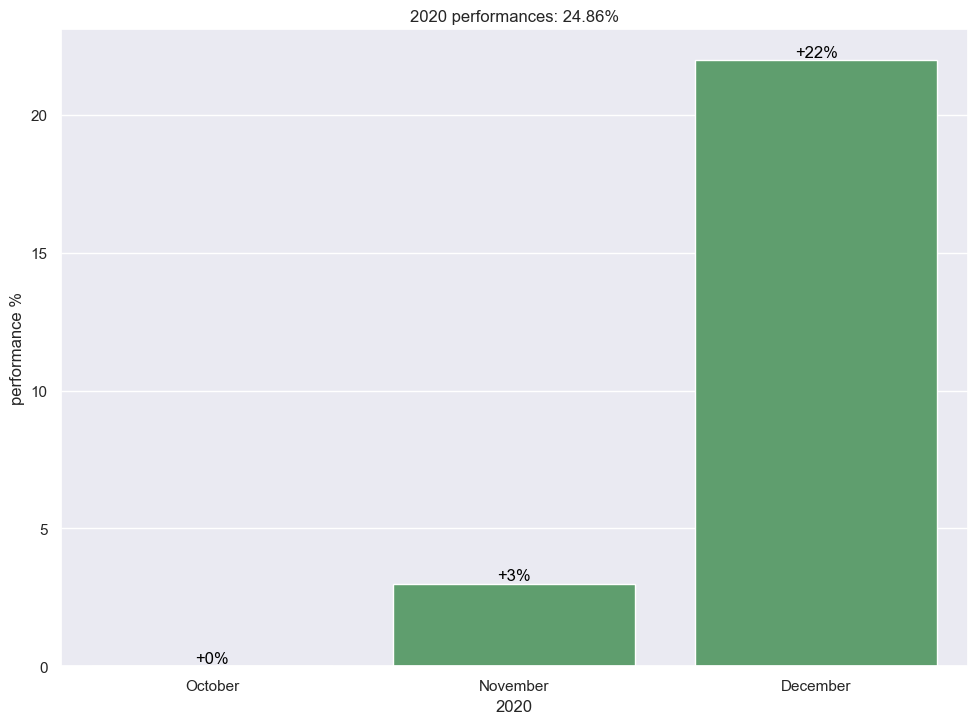

d:\Cryptobots\cBot-Project_jack\backtest\../utilities\backtesting.py:333: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTemp = dfTemp.append(myrow, ignore_index=True)
d:\Cryptobots\cBot-Project_jack\backtest\../utilities\backtesting.py:333: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTemp = dfTemp.append(myrow, ignore_index=True)
d:\Cryptobots\cBot-Project_jack\backtest\../utilities\backtesting.py:333: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTemp = dfTemp.append(myrow, ignore_index=True)
d:\Cryptobots\cBot-Project_jack\backtest\../utilities\backtesting.py:333: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTemp = dfTemp.a

----- 2021 Performances: 321.22% -----


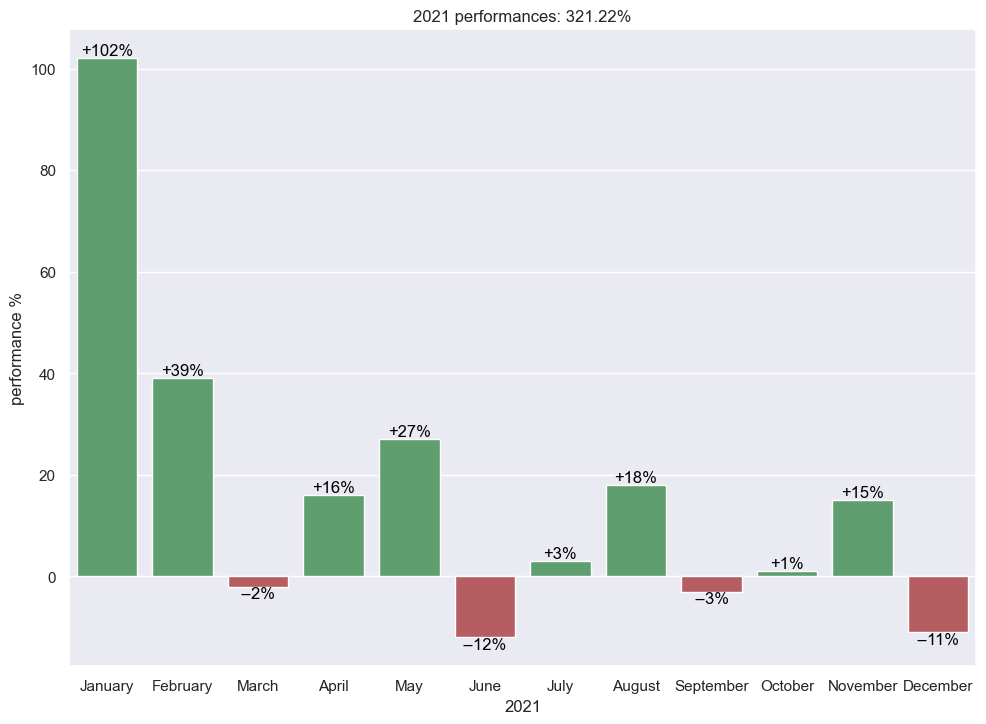

d:\Cryptobots\cBot-Project_jack\backtest\../utilities\backtesting.py:333: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTemp = dfTemp.append(myrow, ignore_index=True)
d:\Cryptobots\cBot-Project_jack\backtest\../utilities\backtesting.py:333: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTemp = dfTemp.append(myrow, ignore_index=True)
d:\Cryptobots\cBot-Project_jack\backtest\../utilities\backtesting.py:333: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTemp = dfTemp.append(myrow, ignore_index=True)
d:\Cryptobots\cBot-Project_jack\backtest\../utilities\backtesting.py:333: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTemp = dfTemp.a

----- 2022 Performances: 17.2% -----


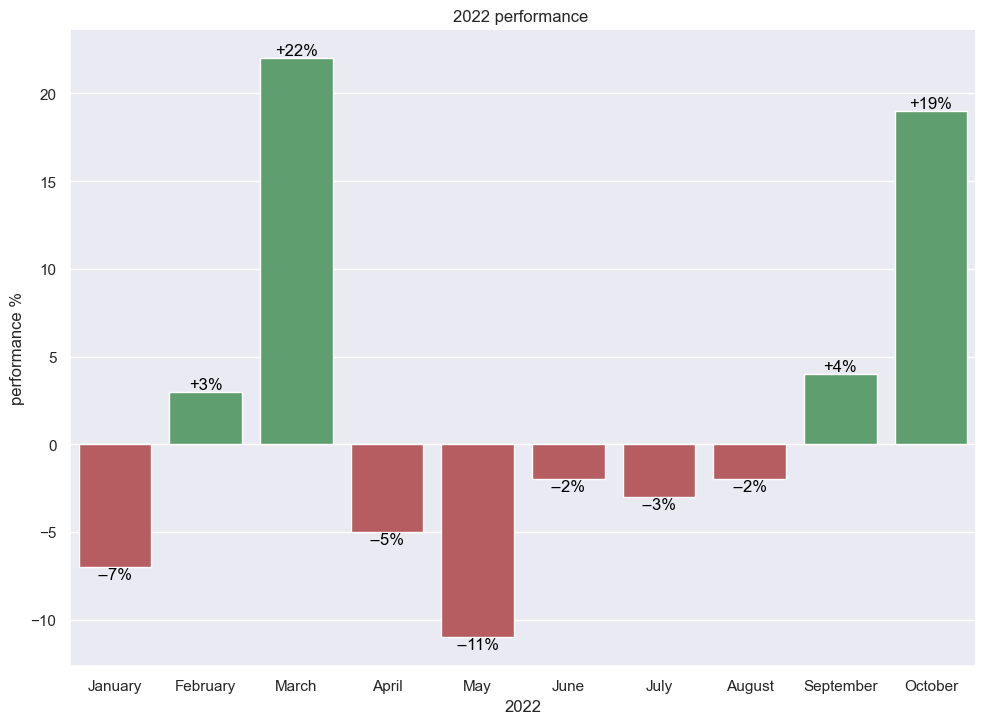

In [11]:
BTobject.plot_bar_by_month(dfTrades=dfTrades)


----- Wallet evolution -----


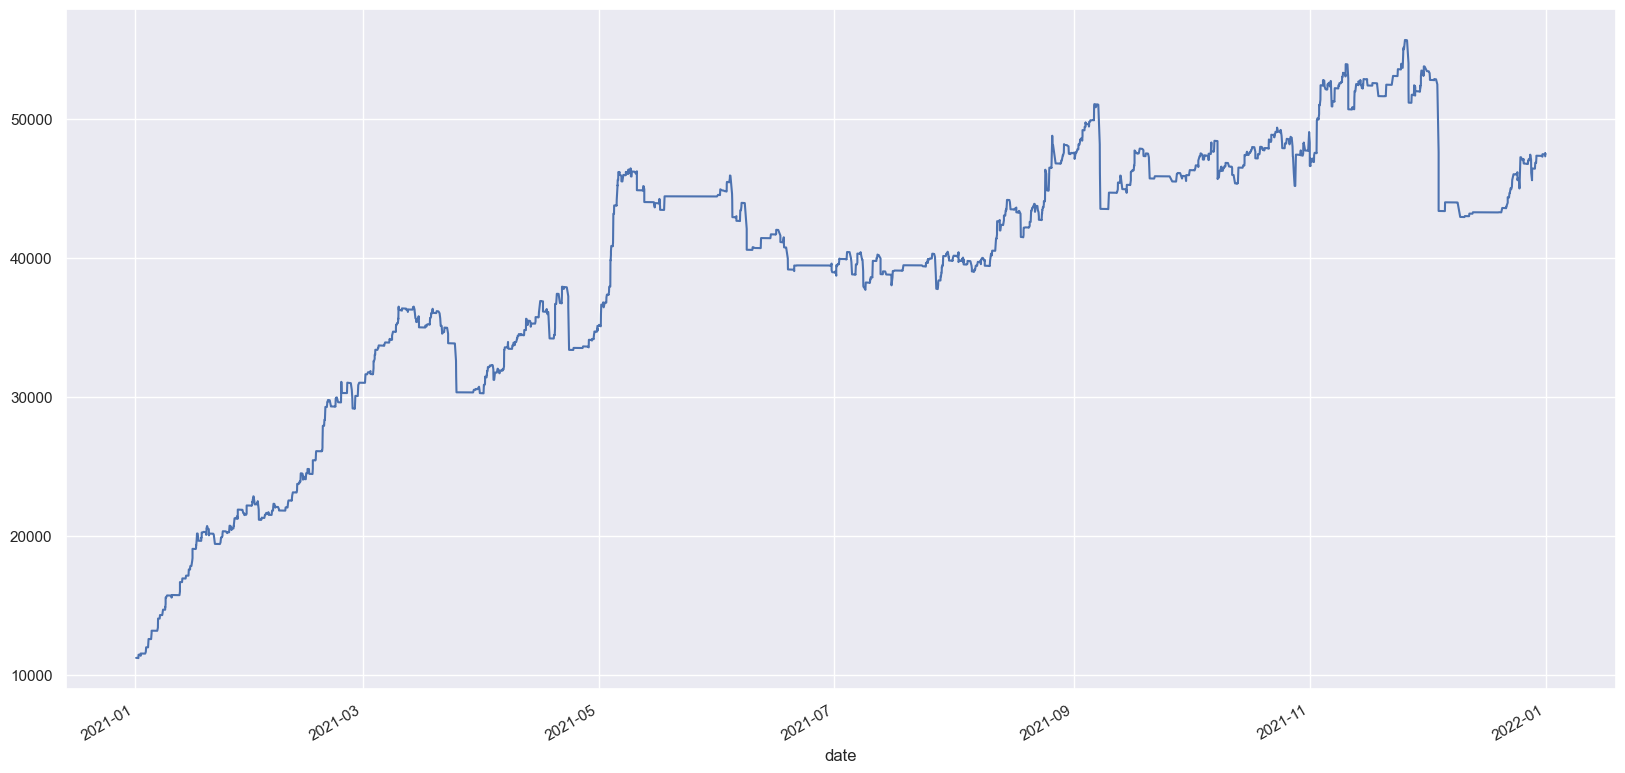

In [12]:
BTobject.plot_wallet_evolution(dfTrades=newDf.loc['2021'])

In [13]:
dfTrades.iloc[-10:]

,date,symbol,position,reason,price,frais,fiat,coins,wallet
3814,2022-11-03 13:00:00,UNI/USD,Buy,Buy Market Order,7.07400,11.328309,0.000000,2540.304603,53938.666835
3815,2022-11-03 14:00:00,CHZ/USD,Sell,Sell Market Order,0.24070,11.550215,18322.123883,0.000000,54273.681711
3816,2022-11-03 14:00:00,UNI/USD,Sell,Sell Market Order,7.21400,11.545227,36636.336059,0.000000,54617.779128
3817,2022-11-03 15:00:00,SAND/USD,Sell,Sell Market Order,0.82415,11.482260,54850.664037,0.000000,54850.664037
3818,2022-11-03 21:00:00,GRT/USD,Buy,Buy Market Order,0.08760,11.518639,36559.430265,208672.547177,54839.145398
3819,2022-11-03 22:00:00,LINK/USD,Buy,Buy Market Order,7.70750,11.516221,18273.957022,2370.931823,54827.629177
3820,2022-11-04 00:00:00,GRT/USD,Sell,Sell Market Order,0.08730,11.476781,36479.593609,0.000000,54753.550632
3821,2022-11-04 00:00:00,LINK/USD,Sell,Sell Market Order,7.83300,11.700051,55039.402525,0.000000,55039.402525
3822,2022-11-04 04:00:00,SUSHI/USD,Buy,Buy Market Order,1.71580,11.558275,36685.229500,10690.415404,55027.844250
3823,2022-11-04 05:00:00,SUSHI/USD,Sell,Sell Market Order,1.75540,11.822552,55439.362149,0.000000,55439.362149
